[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/074_preceiver_intro/074_preceiver_intro.ipynb)

# PerceiverIO: ¿La red neuronal definitiva?

Este es el primero en una serie de posts en los que vamos a aprender sobre la arquitectura de red neuronal conocida como [PerceiverIO](https://arxiv.org/pdf/2107.14795.pdf).

![](https://lh3.googleusercontent.com/355TNHvZGNS2yaYFD1yhlZt_JsyAQGCc8XMWf0bX0FhFK-O7HjJsBrnuOvazj3OfzBkTSZYGJ1wMHPJlYW21Fhhi-5bxYOgk9TqHMIEA0yEGmD9H5A=w1440-rw-v1)

Este arquitectura, introducida por [DeepMind](https://deepmind.com/blog/article/building-architectures-that-can-handle-the-worlds-data), está diseñada para aceptar cualquier tipo de inputs (imágenes, vídeos, texto, nubes de puntos, audio, incluso combinaciones de los mismos) y producir cualquier tipo de output (clasificación, segmentación de imágenes, generación de texto, etc). Para ello se basa en la arquitectura de *Transformers* (de la cual hemos hablado en posts anteriores) para el procesamiento de características intermedias y proyecciones, tanto a la entrada como a la salida. De cumplir lo que promete, este modelo sería capaz de llevar a cabo multitud de tareas que hoy en día requieren de diferentes arquitecturas específicas que pueden funcionar bien en un dominio pero no en otros. Tener una única arquitectura puede ser muy atractivo para muchas aplicaciones, ya que es más fácil de optimizar. Además, las arquitecturas basadas en *Transformers* no hacen presunciones sobre la naturaleza de los datos (como lo hace las redes convolucionales o recurrentes) eliminando posibles fuentes de sesgo y aumentando la flexibilidad y capacidad de generalización. En este post y los siguientes vamos a aprender sobre esta arquitectura y ver si realmente nos da lo que promete 😀

## Perceiver

Antes de meternos de lleno con la arquitectura de *PercieverIO* vamos a trabajar con la arquitectura [Perceiver](https://arxiv.org/pdf/2103.03206.pdf), un modelo desarrollado por los mismos autores y que sienta las bases para el modelo más general. En el siguiente [video](https://www.youtube.com/watch?v=P_xeshTnPZg) del canal de [Yannic Kilcker](https://www.youtube.com/channel/UCZHmQk67mSJgfCCTn7xBfew) encontrarás una muy buena explicación (en inglés) del modelo y cómo funciona. Este otro [video](https://www.youtube.com/watch?v=WJWBq4NZfvY) también es muy útil.

![](https://www.zdnet.com/a/hub/i/r/2021/07/08/aa90f2e1-8bdf-47dd-8fb2-2d404fc0c0f8/resize/1200xauto/bd158149b1ede83422171be4a2aa7f79/deepmind-2021-perceiver.jpg)

Como puedes ver en el diagrama anterior el modelo está basado en la arquitectura *Transoformers*. Sin embargo, existe una gran diferencia. En la arquitectura *Transformers* original, usamos el mismo tensor como *query*, *keys* y *values* para calcular la matriz de atención y aplicar las operaciones de *multi-head self attention*. En la arquitectura *Perceiver*, sin embargo, usamos dos tensores diferentes, uno para la *query* y otro para las *keys* y *values*. Aquí la clave es ver que las dimensiones de los tensores son diferentes, siendo la dimensión resultantes de aplicar el mecanismo de atención mucho menor que la original. De esta manera, el modelo es capaz de trabajar con inputs de dimensión arbitraria (lo que permite la multi-modalidad) y más grandes que la posible en *Transformers*, ya que se reduce a un valor más pequeño para las siguientes capas. Esta operación se utiliza a la entrada del modelo, a partir de la cual ya sí que usa un *Transformer* "normal y corriente". La segunda diferencia es que los inputs de la red son utilizados varias veces durante el *forward*, similar a lo que hacemos con redes recurrentes. De esta manera, el modelo es capaz de extraer la información necesaria de los *inputs* en varias etapas. Por último, el *Perceiver* reutiliza (de manera opcional) los pesos de varias capas, de nuevo similar a lo que hacemos en redes recurrentes (aunque en vez de darle datos en diferentes pasos de tiempo, le damos los mismos datos todo el rato). El modelo de *PerceiverIO* simplemente añadirá la capacidad de generar *outputs* de diferentes dimensiones, pero de esto hablaremos en posts futuros. Ahora, vamos a ver todas estas características poco a poco, en la implementación de la arquitectura *Perceiver* en Pytorch con un ejemplo de aplicación en la clasificación de imágenes.

## *Cross-Attention*

La primera capa que vemos en el modelo es la de *cross-attention*. Esta capa está basada en [mecanismos de atención](https://juansensio.com/blog/060_attention), [self-attention](https://juansensio.com/blog/061_self_attention) y [multi-head self-attention](https://juansensio.com/blog/062_multihead_attention) de lo que ya hemos hablado en detalle en los posts linkados. Si no estás familiarizado con estos conceptos, te recomiendo encarecidamente que inviertas un poco de tiempo en ello ya que te será muy útil de ahora en adelante para entender bien cómo funciona el *Perceiver*. La siguiente clase implementa el cálculo del *multi-head self-attention*, la principal característica es el uso de diferentes tensores para las *queries* y las *keys* y *values*.

In [62]:
# https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
# https://github.com/esceptico/perceiver-io/blob/master/src/perceiver/attention.py

import math
import torch

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, kv_dim, q_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.n_embd = q_dim
        self.n_heads = n_heads
        assert self.n_embd % self.n_heads == 0
        # key, query, value projections
        self.key = torch.nn.Linear(kv_dim, self.n_embd)
        self.query = torch.nn.Linear(q_dim, self.n_embd)
        self.value = torch.nn.Linear(kv_dim, self.n_embd)
        # regularization
        self.attn_drop = torch.nn.Dropout(attn_pdrop)
        self.resid_drop = torch.nn.Dropout(resid_pdrop)
        # output projection
        self.proj = torch.nn.Linear(self.n_embd, q_dim)

    def forward(self, kv, q, mask = None): 
        B, M, C = kv.size()
        B, N, D = q.size()
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(kv).view(B, M, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, M, hs)
        q = self.query(q).view(B, N, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, N, hs)
        v = self.value(kv).view(B, M, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, M, hs)
        # attention (B, nh, N, hs) x (B, nh, hs, M) -> (B, nh, N, M)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if mask is not None:
            att = att.masked_fill(self.mask[:,:,:N,:M] == 0, float('-inf')) 
        att = torch.nn.functional.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, N, M) x (B, nh, M, hs) -> (B, nh, N, hs)
        y = y.transpose(1, 2).contiguous().view(B, N, D) # re-assemble all head outputs side by side
        return self.resid_drop(self.proj(y)) # B, N, D

In [63]:
mha = MultiHeadAttention(3, 512, n_heads=2)

mha

MultiHeadAttention(
  (key): Linear(in_features=3, out_features=512, bias=True)
  (query): Linear(in_features=512, out_features=512, bias=True)
  (value): Linear(in_features=3, out_features=512, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (resid_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=512, out_features=512, bias=True)
)

In [65]:
kv = torch.randn((32, 28*28, 3)) # B, num pixels (num patches en vit), num channels (n_embed en vit)
q = torch.randn((32, 128, 512))
mask = None

outputs = mha(kv, q, mask)
outputs.shape

torch.Size([32, 128, 512])

## Perceiver

En el ejemplo anterior le hemos dado valores aleatorios de *query*, *keys* y *values*. Sin embargo, en la arquitectura final aprenderemos los valores de *q* a la entrada (de manera que el modelo podrá elegir aquellas *queries* más útiles). Para las capas intermedias, tanto *query*, *keys* y *values* serán las mismas, y vendrán de la salida de la capa anterior. 

In [144]:
class Block(torch.nn.Module):
    def __init__(self, kv_dim, q_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.ln1_kv = torch.nn.LayerNorm(kv_dim)
        self.ln1_q = torch.nn.LayerNorm(q_dim)
        self.ln2 = torch.nn.LayerNorm(q_dim)
        self.attn = MultiHeadAttention(kv_dim, q_dim, n_heads, attn_pdrop, resid_pdrop)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(q_dim, 4 * q_dim),
            torch.nn.GELU(),
            torch.nn.Linear(4 * q_dim, q_dim),
            torch.nn.Dropout(resid_pdrop),
        )

    def forward(self, kv, q, mask=None):
        x = q + self.attn(self.ln1_kv(kv), self.ln1_q(q), mask)
        x = x + self.mlp(self.ln2(x))
        return x

In [145]:
class Perceiver(torch.nn.Module):
    # ejemplo sin recurrencia para clasificación
    def __init__(self, num_latents, latent_dim, input_dim, num_blocks, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        # se podrían separar los params en función de si es cross o self ...
        super().__init__()
        self.num_blocks = num_blocks
        self.latents = torch.nn.Parameter(torch.randn(num_latents, latent_dim))
        # encode
        self.cross_attn = Block(
            kv_dim=input_dim, 
            q_dim=latent_dim, 
            n_heads=n_heads, 
            attn_pdrop=attn_pdrop, 
            resid_pdrop=resid_pdrop
        )
        # process
        self.self_attention_blocks = torch.nn.ModuleList([
            Block( # se podrían hacer bloques diferenciados para en el forward pasar solo x
                kv_dim=latent_dim,
                q_dim=latent_dim,
                n_heads=n_heads, 
                attn_pdrop=attn_pdrop, 
                resid_pdrop=resid_pdrop
            ) for _ in range(num_blocks)
        ])

    def forward(self, x, mask = None):
        B = x.size(0)
        if mask is not None:
            mask = mask[None, None, :, :] # esto no se si está bien :S
        x = self.cross_attn(
            kv=x,
            q=self.latents.repeat(B, 1, 1),
            mask=mask
        )
        for _ in range(self.num_blocks):
            for self_attn_layer in self.self_attention_blocks:
                x = self_attn_layer(x, x)
        return x


In [146]:
model = Perceiver(num_latents=128, latent_dim=512, input_dim=3, num_blocks=2, n_heads=2)

model

Perceiver(
  (cross_attn): Block(
    (ln1_kv): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
    (ln1_q): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (attn): MultiHeadAttention(
      (key): Linear(in_features=3, out_features=512, bias=True)
      (query): Linear(in_features=512, out_features=512, bias=True)
      (value): Linear(in_features=3, out_features=512, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (resid_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=512, out_features=512, bias=True)
    )
    (mlp): Sequential(
      (0): Linear(in_features=512, out_features=2048, bias=True)
      (1): GELU()
      (2): Linear(in_features=2048, out_features=512, bias=True)
      (3): Dropout(p=0.0, inplace=False)
    )
  )
  (self_attention_blocks): ModuleList(
    (0): Block(
      (ln1_kv): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln1_q): Laye

In [70]:
outputs = model(torch.randn((32, 28*28, 3))) # B, num pixels (num patches en vit), num channels (n_embed en vit)

outputs.shape

torch.Size([32, 128, 512])

## Clasificación de imágenes

Vamos a entrenar un clasificador de imágenes usando la arquitectura *Perceiver*. Para ello, usaremos el dataset CIFAR10.

In [71]:
import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).float(), torch.tensor(self.labels[ix]).long()

In [72]:
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}

ds['train'].imgs.shape, ds['test'].imgs.shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [73]:
batch_size = 64
num_workers = 0

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

(torch.Size([64, 32, 32, 3]), torch.Size([64]))

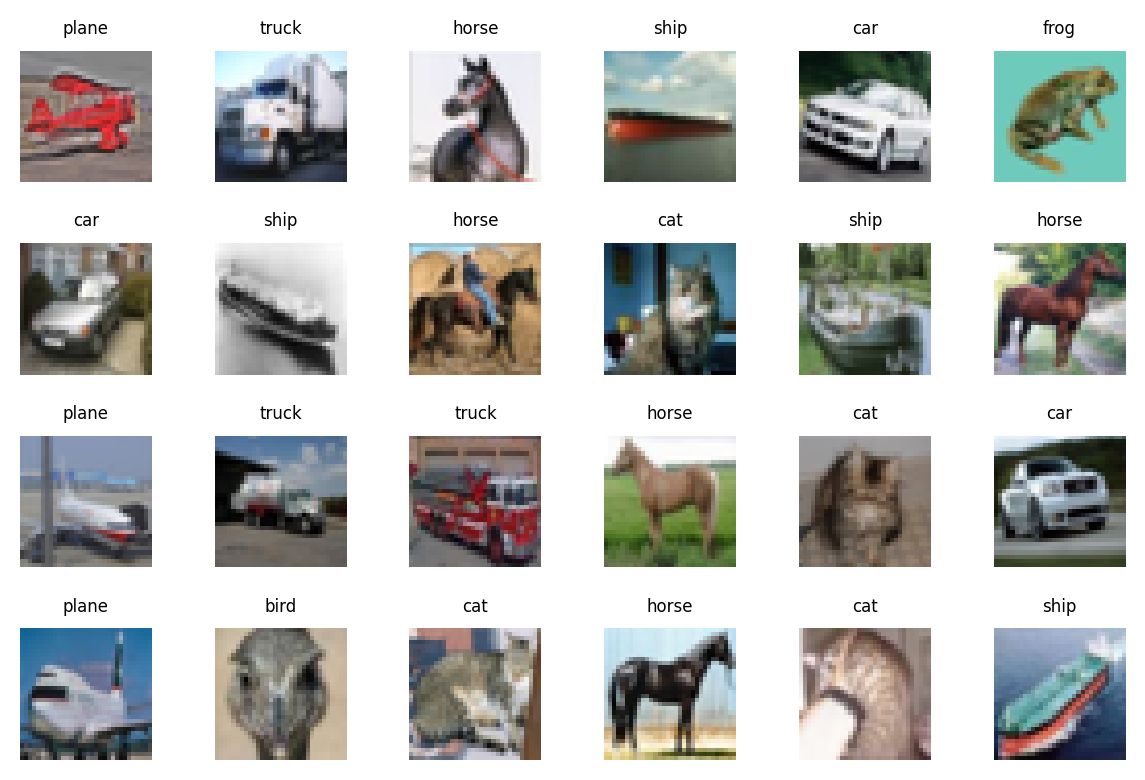

In [74]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img)
        ax.set_title(ds['train'].classes[labels[ix].item()], fontsize=6)
        ax.axis('off')
plt.tight_layout()
plt.show()

Como ya comentamos en los posts anteriores, los *Transformers* son equivariantes al orden de las entradas. Esto significa que no prestan atención al orden en el que la damos los inputs, lo cual puede ser importante para la tarea en cuestión. En el caso de las redes convolucionales, este concepto se introduce de manera intrínsica en el modelo (usando kernels que solo prestan atención al entorno más cercano de los pixeles, y reusando los kernels en toda la imágen). En el caso de los *Transformers*, la solución más común es el uso de *positional encoding*. Éstos pueden ser aprendidos (como vimos en los ejemplos de *ViT*) o fijados. En el caso del *Perceiver*, los autores proponen el uso de *Fourier features*, que consiste en concatenar en la dimensión de los canales, para cada pixel de la imagen, una serie de valores que codifican su posición relativa para que el modelo pueda usar esta información.

In [147]:
from math import pi, log

def fourier_encode(x, max_freq, num_bands = 4, base = 2):
    x = x.unsqueeze(-1)
    device, dtype, orig_x = x.device, x.dtype, x
    scales = torch.logspace(0., log(max_freq / 2) / log(base), num_bands, base = base, device = device, dtype = dtype)
    scales = scales[(*((None,) * (len(x.shape) - 1)), ...)]
    x = x * scales * pi
    x = torch.cat([x.sin(), x.cos()], dim=-1)
    x = torch.cat((x, orig_x), dim = -1)
    return x

In [151]:
# https://github.com/lucidrains/perceiver-pytorch/blob/main/perceiver_pytorch/perceiver_pytorch.py

from einops import rearrange, repeat

b, *axis, _, device = *imgs.shape, imgs.device

# por cada eje, tantos valores como píxeles entre -1 y 1
axis_pos = list(map(lambda size: torch.linspace(-1., 1., steps = size, device = device), axis))
print(axis_pos[0].shape, axis_pos[1].shape)

# para cada pixel, su posición para cada eje
pos = torch.stack(torch.meshgrid(*axis_pos), dim = -1)
print(pos.shape)

# añadimos fourier features
max_freq, num_freq_bands, freq_base = 10, 6, 2
enc_pos = fourier_encode(pos, max_freq, num_freq_bands, base = freq_base)
print(enc_pos.shape)

# reordenar dimensiones y repetir para todo el batch
enc_pos = rearrange(enc_pos, '... n d -> ... (n d)')
print(enc_pos.shape)

enc_pos = repeat(enc_pos, '... -> b ...', b = b)
print(enc_pos.shape)

torch.Size([32]) torch.Size([32])
torch.Size([32, 32, 2])
torch.Size([32, 32, 2, 13])
torch.Size([32, 32, 26])
torch.Size([64, 32, 32, 26])


Así pues, alimentaremos nuestro modelo con batches de imágenes de dimensiones $(H, W, C)$, añadiremos el *positional encoding* y "estiraremos" la imagen para tener una secuencia de pixels de dimensiones $(H \times W, C + F)$. Esto se lo daremos a nuestro *Perceiver*, que proyectará estas imágenes a la dimensión latente (de la cual nosotros controlamos su dimensión) y las procesará en capas consecutivas de *Transformer*. Finalmente, calcularemos el valor medio de las últimas características y aplicaremos un clasificador lineal que nos dará la distribución de probabilidad sobre las diferentes clases, exactamente igual que hacemos con redes convolucionales.

In [81]:
# https://github.com/lucidrains/perceiver-pytorch/blob/main/perceiver_pytorch/perceiver_pytorch.py

class Model(torch.nn.Module):
    def __init__(self, num_classes, max_freq, num_freq_bands, num_latents, latent_dim, input_dim, num_blocks, freq_base = 2, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.num_freq_bands = num_freq_bands
        self.freq_base = freq_base
        self.max_freq = max_freq
        fourier_channels = (2 * ((num_freq_bands * 2) + 1))
        input_dim += fourier_channels
        self.perceiver = Perceiver(num_latents, latent_dim, input_dim, num_blocks, n_heads, attn_pdrop, resid_pdrop)
        self.fc = torch.nn.Linear(latent_dim, num_classes)

    def forward(self, x, mask = None):
        # fourier encoding
        b, *axis, _, device = *x.shape, x.device
        axis_pos = list(map(lambda size: torch.linspace(-1., 1., steps = size, device = device), axis))
        pos = torch.stack(torch.meshgrid(*axis_pos), dim = -1)
        enc_pos = fourier_encode(pos, self.max_freq, self.num_freq_bands, base = self.freq_base)
        enc_pos = rearrange(enc_pos, '... n d -> ... (n d)')
        enc_pos = repeat(enc_pos, '... -> b ...', b = b)
        x = torch.cat((x, enc_pos), dim = -1)
        x = rearrange(x, 'b ... d -> b (...) d')
        # apply perceiver
        x = self.perceiver(x, mask)
        # final classification
        return self.fc(x.mean(1))

In [83]:
model = Model(num_classes=10, max_freq=10, num_freq_bands=6, num_latents=256, latent_dim=512, input_dim=3, num_blocks=2)

outputs = model(imgs)

outputs.shape

torch.Size([64, 10])

Ahora ya podemos entrenar nuestro modelo como hemos hecho tantas veces anteriormente.

In [134]:
from tqdm import tqdm
import torch.nn.functional as F

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cuda", overfit=False):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        # como cambiar el shuffle a False si overfit ?
        for batch in bar:
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
            if overfit: 
                break
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        # eval
        model.eval()
        l, a = [], []
        if overfit:
            bar = tqdm(dl['train'])
        else:
            bar = tqdm(dl['test'])
        with torch.inference_mode():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
                if overfit: 
                    break
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
    return hist

In [135]:
import pandas as pd

def plot_hist(hist):
    fig = plt.figure(figsize=(10, 3), dpi=100)
    df = pd.DataFrame(hist)
    ax = plt.subplot(1, 2, 1)
    df[['loss', 'test_loss']].plot(ax=ax)
    ax.grid(True)
    ax = plt.subplot(1, 2, 2)
    df[['acc', 'test_acc']].plot(ax=ax)
    ax.grid(True)
    plt.show()

In [136]:
model = Model(num_classes=10, max_freq=5, num_freq_bands=3, num_latents=32, latent_dim=32, input_dim=3, num_blocks=3)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=64, shuffle=True, num_workers=0),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=64, shuffle=False, num_workers=0)
}

In [137]:
hist = train(model, dl, optimizer, epochs=30, overfit=False)

testing... loss 2.0302 acc 0.2396: 100%|██████████| 157/157 [00:02<00:00, 77.05it/s]


Epoch 1/30 loss 2.1071 acc 0.1975 test_loss 2.0302 test_acc 0.2396


testing... loss 1.9135 acc 0.2927: 100%|██████████| 157/157 [00:02<00:00, 74.86it/s]


Epoch 2/30 loss 1.9735 acc 0.2656 test_loss 1.9135 test_acc 0.2927


testing... loss 1.8190 acc 0.3367: 100%|██████████| 157/157 [00:02<00:00, 76.31it/s]


Epoch 3/30 loss 1.8665 acc 0.3165 test_loss 1.8190 test_acc 0.3367


testing... loss 1.7199 acc 0.3662: 100%|██████████| 157/157 [00:02<00:00, 77.60it/s]


Epoch 4/30 loss 1.7689 acc 0.3554 test_loss 1.7199 test_acc 0.3662


testing... loss 1.6256 acc 0.4097: 100%|██████████| 157/157 [00:02<00:00, 77.31it/s]


Epoch 5/30 loss 1.6946 acc 0.3848 test_loss 1.6256 test_acc 0.4097


testing... loss 1.6351 acc 0.4032: 100%|██████████| 157/157 [00:00<00:00, 172.54it/s]


Epoch 6/30 loss 1.6341 acc 0.4076 test_loss 1.6351 test_acc 0.4032


testing... loss 1.5646 acc 0.4378: 100%|██████████| 157/157 [00:00<00:00, 169.73it/s]


Epoch 7/30 loss 1.5919 acc 0.4266 test_loss 1.5646 test_acc 0.4378


testing... loss 1.5858 acc 0.4267: 100%|██████████| 157/157 [00:02<00:00, 76.21it/s]


Epoch 8/30 loss 1.5541 acc 0.4403 test_loss 1.5858 test_acc 0.4267


testing... loss 1.5107 acc 0.4571: 100%|██████████| 157/157 [00:02<00:00, 77.64it/s]


Epoch 9/30 loss 1.5288 acc 0.4518 test_loss 1.5107 test_acc 0.4571


testing... loss 1.4837 acc 0.4615: 100%|██████████| 157/157 [00:02<00:00, 75.01it/s]


Epoch 10/30 loss 1.5008 acc 0.4623 test_loss 1.4837 test_acc 0.4615


testing... loss 1.4592 acc 0.4810: 100%|██████████| 157/157 [00:02<00:00, 76.76it/s]


Epoch 11/30 loss 1.4763 acc 0.4700 test_loss 1.4592 test_acc 0.4810


testing... loss 1.4601 acc 0.4773: 100%|██████████| 157/157 [00:02<00:00, 75.88it/s]


Epoch 12/30 loss 1.4515 acc 0.4774 test_loss 1.4601 test_acc 0.4773


testing... loss 1.4309 acc 0.4861: 100%|██████████| 157/157 [00:02<00:00, 76.98it/s]


Epoch 13/30 loss 1.4247 acc 0.4899 test_loss 1.4309 test_acc 0.4861


testing... loss 1.4058 acc 0.4932: 100%|██████████| 157/157 [00:02<00:00, 77.68it/s]


Epoch 14/30 loss 1.4102 acc 0.4938 test_loss 1.4058 test_acc 0.4932


testing... loss 1.4100 acc 0.4952: 100%|██████████| 157/157 [00:02<00:00, 77.77it/s]


Epoch 15/30 loss 1.3883 acc 0.5024 test_loss 1.4100 test_acc 0.4952


testing... loss 1.3862 acc 0.5029: 100%|██████████| 157/157 [00:02<00:00, 78.11it/s]


Epoch 16/30 loss 1.3687 acc 0.5086 test_loss 1.3862 test_acc 0.5029


testing... loss 1.3686 acc 0.5128: 100%|██████████| 157/157 [00:02<00:00, 78.26it/s]


Epoch 17/30 loss 1.3516 acc 0.5154 test_loss 1.3686 test_acc 0.5128


testing... loss 1.3841 acc 0.5023: 100%|██████████| 157/157 [00:02<00:00, 77.22it/s]


Epoch 18/30 loss 1.3349 acc 0.5210 test_loss 1.3841 test_acc 0.5023


testing... loss 1.3623 acc 0.5161: 100%|██████████| 157/157 [00:02<00:00, 77.28it/s]


Epoch 19/30 loss 1.3208 acc 0.5283 test_loss 1.3623 test_acc 0.5161


testing... loss 1.3926 acc 0.5089: 100%|██████████| 157/157 [00:02<00:00, 77.76it/s]


Epoch 20/30 loss 1.3032 acc 0.5343 test_loss 1.3926 test_acc 0.5089


testing... loss 1.3503 acc 0.5171: 100%|██████████| 157/157 [00:02<00:00, 77.16it/s]


Epoch 21/30 loss 1.2909 acc 0.5366 test_loss 1.3503 test_acc 0.5171


testing... loss 1.3352 acc 0.5252: 100%|██████████| 157/157 [00:02<00:00, 78.16it/s]


Epoch 22/30 loss 1.2753 acc 0.5438 test_loss 1.3352 test_acc 0.5252


testing... loss 1.3416 acc 0.5229: 100%|██████████| 157/157 [00:02<00:00, 77.43it/s]


Epoch 23/30 loss 1.2644 acc 0.5471 test_loss 1.3416 test_acc 0.5229


testing... loss 1.3133 acc 0.5301: 100%|██████████| 157/157 [00:02<00:00, 78.36it/s]


Epoch 24/30 loss 1.2507 acc 0.5510 test_loss 1.3133 test_acc 0.5301


testing... loss 1.3005 acc 0.5364: 100%|██████████| 157/157 [00:02<00:00, 77.89it/s]


Epoch 25/30 loss 1.2388 acc 0.5566 test_loss 1.3005 test_acc 0.5364


testing... loss 1.3198 acc 0.5273: 100%|██████████| 157/157 [00:02<00:00, 77.99it/s]


Epoch 26/30 loss 1.2270 acc 0.5601 test_loss 1.3198 test_acc 0.5273


testing... loss 1.3177 acc 0.5289: 100%|██████████| 157/157 [00:02<00:00, 77.65it/s]


Epoch 27/30 loss 1.2135 acc 0.5657 test_loss 1.3177 test_acc 0.5289


testing... loss 1.3040 acc 0.5389: 100%|██████████| 157/157 [00:02<00:00, 77.89it/s]


Epoch 28/30 loss 1.2064 acc 0.5693 test_loss 1.3040 test_acc 0.5389


testing... loss 1.3029 acc 0.5390: 100%|██████████| 157/157 [00:02<00:00, 77.72it/s]


Epoch 29/30 loss 1.1915 acc 0.5727 test_loss 1.3029 test_acc 0.5390


testing... loss 1.2782 acc 0.5486: 100%|██████████| 157/157 [00:02<00:00, 77.89it/s]

Epoch 30/30 loss 1.1864 acc 0.5747 test_loss 1.2782 test_acc 0.5486


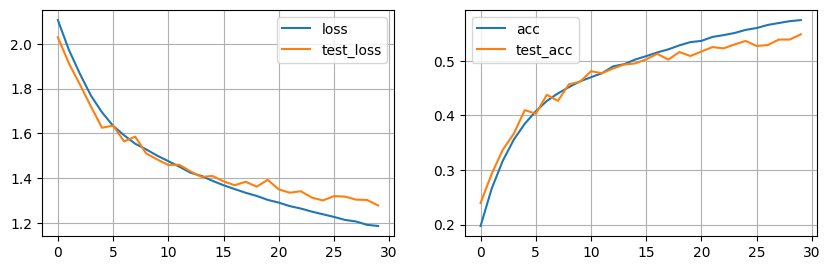

In [140]:
plot_hist(hist)

Tras 30 epochs nuestro modelo está convergiendo ! Los resultados no son nada del otro mundo, sin embargo es un buen punto de partida para empezar a experimentar con esta nueva arquitectura de red neuronal.

In [142]:
imgs, labels = next(iter(dl['train']))

model.eval()
with torch.inference_mode():
    logits = model(imgs.cuda())
    preds = torch.argmax(logits, axis=1).cpu()

preds.shape

torch.Size([64])

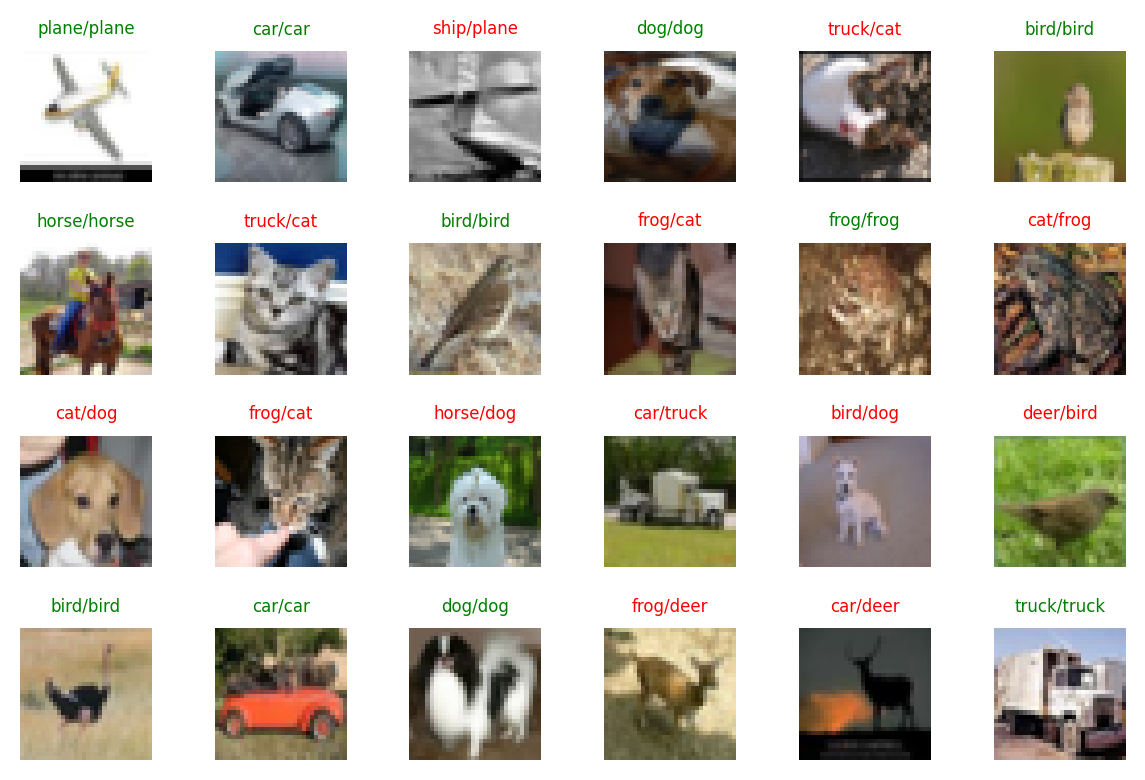

In [143]:
fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img)
        gt = ds['test'].classes[labels[ix].item()]
        pr = ds['test'].classes[preds[ix].item()]
        ax.set_title(f'{pr}/{gt}', fontsize=6, color='green' if pr == gt else 'red')
        ax.axis('off')
plt.tight_layout()
plt.show()

En el siguiente post extenderemos nuestra arquitectura para adaptarla al modelo de *PerceiverIO*, a partir de lo cual empezaremos a experimentar con diferentes tareas y modalidades de datos para demostrar la potencialidad de esta red neuronal.

## Resumen

En este post hemos introducido la arquitectura de red neuronal *Perceiver*, base del modelo más avanzado *Perceiver IO* que veremos en los siguientes posts. Este modelo se basa en *Transformers* para la extracción de características de nuestros datos. Gracias al uso de una primera capa de *cross-attention* con un vector de *query* aprendido y con dimensiones fijas, podemos proyectar nuestros *inputs* a la dimensión deseada. Esto nos da dos ventajas: en primer lugar, podemos usar inputs mucho más grandes que con *Transformers* tradicionales. Por otro lado, podemos usar inputs multi-modales. En este post hemos visto un ejemplo para clasificación de imagen con el dataset CIFAR10. A diferencia de otras arquitecturas de *transformers*, como *ViT*, *Perceiver* es capaz de atender a todos los pixels de la imagen sin necesitar extraer y proyectar *patches*. 

## Recursos

- [Paper](https://arxiv.org/pdf/2103.03206.pdf)
- [Blog](https://deepmind.com/blog/article/building-architectures-that-can-handle-the-worlds-data) DeepMind.
- Videos:
    1. [Yannic Kilcher](https://www.youtube.com/watch?v=P_xeshTnPZg)
    2. [The AI Epiphany](https://www.youtube.com/watch?v=WJWBq4NZfvY&feature=youtu.be)
- Código:
    1. Implementación original de [DeepMind](https://github.com/deepmind/deepmind-research/tree/master/perceiver) (JAX)
    2. Pytorch: [lucidrains](https://github.com/lucidrains/perceiver-pytorch), [esceptico](https://github.com/esceptico/perceiver-io)